In [12]:
#anaconda3
import mdtraj as md
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math

In [11]:

#info
#some are united in this analysis 
# H alpha helix
# B residue in isolated beta bridge
# E extended strand in beta ladder
# G 3-helix
# I 5-helix
# T hydrogen bonded turn
# S bend
# '' loops
# NA for not residues (capping molecules) -> removed in next step



In [13]:
def counts(data):
    #create list for each aminoacid
    positions = {i: {'H':0,'B':0,'G':0,'T':0,'S':0,' ':0} for i in range(0, 11)} 
    matrix = np.array(data)
    #loop through the positions and count ss for each position and add 1 for each count
    for pos in range(0,11):
        for row in matrix:
            letter = row[pos]
            if letter == 'B':
                positions[pos]['B'] += 1
            if letter == 'I':
                positions[pos]['G'] += 1
            elif letter == 'E':
                positions[pos]['B'] += 1
            else:
                positions[pos][letter] += 1

    #change the position number with the name of the aminoacids
    peptide = ['1K', '2Y' ,'3T' ,'4E','5D','6G','7D','8K','9L','10V','11A'] # control KYTEDGDKLVA
    positions=dict(zip(peptide,list(positions.values()))) 
    big_array = np.array([list(data_dict.values()) for data_dict in positions.values()])

    return big_array


In [31]:
def plotting(dataframe, err):
    df = pd.DataFrame(dataframe)
    df_e = pd.DataFrame(err)
    t_df = df.transpose()
    t_dfe = df_e.transpose()
    plot = t_df.plot.bar(yerr=t_dfe, width=0.9, linewidth=0.1, figsize = (15, 9),fontsize =32, legend=None)
    plot.set_ylabel('Frequency', fontsize = 35)
    plot.text(0.5, 1.05, 'DSSP Control in 0% TFE starting Helical', ha='center', fontsize = 35, transform=plot.transAxes) #change this 0 to 70% of TFE
    plot.set_xticklabels(plot.get_xticklabels(), rotation=0)
    #plot.legend(fontsize = 21, bbox_to_anchor=(0.53, 0.83), ncol = 3)
    for i in range(1, 11):
        y_value = i * 0.1
        plt.axhline(y=y_value, color='gray', alpha=0.2,zorder=0)
    for axis in ['top', 'bottom', 'left', 'right']:
        plot.spines[axis].set_linewidth(2.6)
        plot.spines[axis].set_color('gray')
        plot.spines[axis].set_alpha(0.6)

    return plot



In [25]:
folder_path = 'traj_c/' # M0: traj_c // M7: trajM7controlHelix or trajM7contr

mean = []

#open files and dssp analysis with mdtraj
file_pairs = [(f'mdAlignCG{i}.pdb', f'mdAlignCG{i}.xtc') for i in range(12, 17)] #1,12 for unfolded start  - 12,17 for helical start
for pdb_file, xtc_file in file_pairs:
    pdb_path = os.path.join(folder_path, pdb_file)
    xtc_file = os.path.join(folder_path, xtc_file)
    traj = md.load(xtc_file, top=pdb_path)
    dssp_NA = md.compute_dssp(traj, simplified=False)
    dssp = dssp_NA[20000:40001, 1:12]
   
    counts(dssp)
    

    mean.append(counts(dssp))
    



In [26]:
#calculating the probability
result = mean
row_sums = np.sum(result, axis=2, keepdims=True)
result = np.where(row_sums, result / row_sums, result)



In [27]:
#error bars (SEM)
calc_mean = result
sd = result
calc_mean = np.mean(result, axis=0)
sem = np.std(sd, axis=0) / np.sqrt(sd.shape[0])


In [28]:
#dictionaries and lists
rowname = ['K1', 'Y2' ,'T3' ,'E4','D5','G6','D7','K8','L9','V10','A11']
colname = ['Alpha-helix','Beta','3-helix','Turn','Bend','Random']
aa_err = {rowname[row]: {colname[col]: sem[row][col] for col in range(6)} for row in range(11)}
aa_mean = {rowname[row]: {colname[col]: calc_mean[row][col] for col in range(6)} for row in range(11)}


<Axes: ylabel='Frequency'>

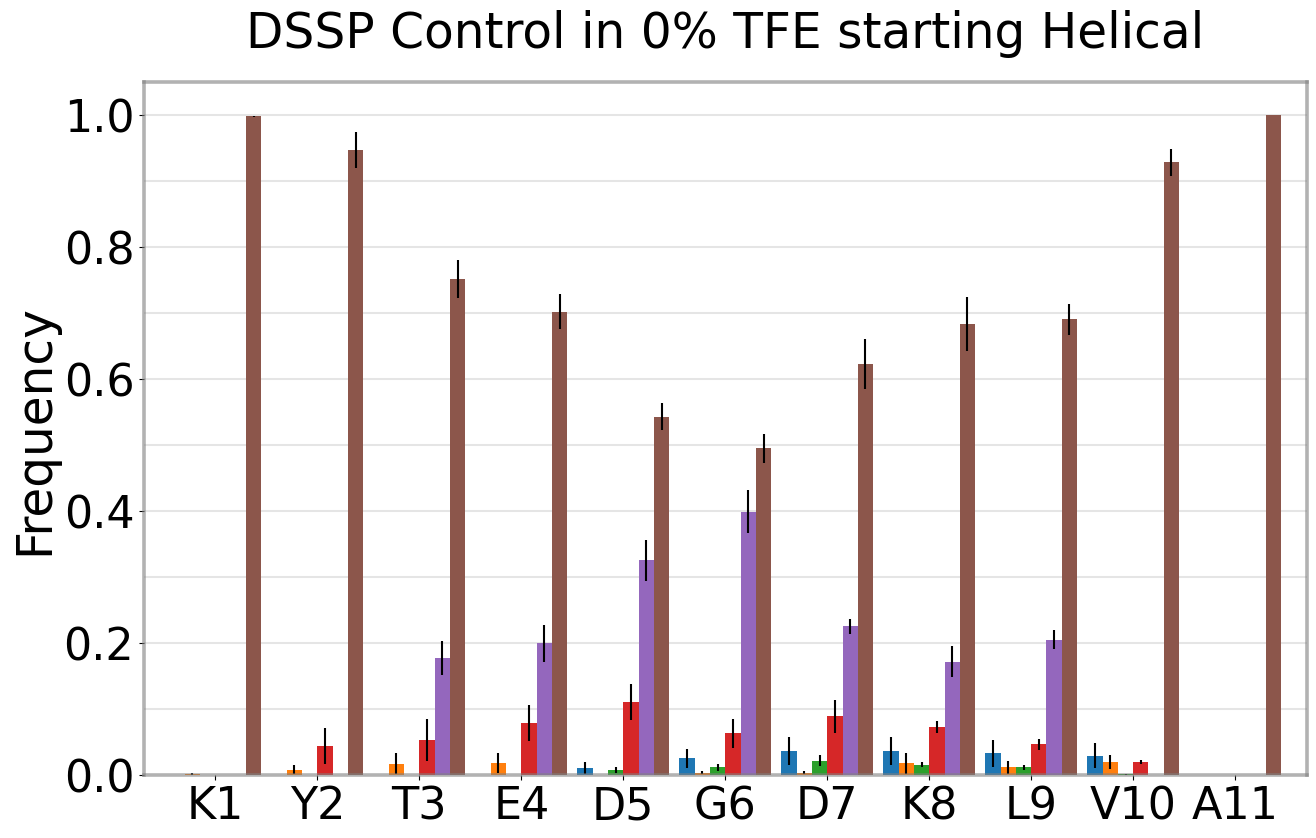

In [32]:
plotting(aa_mean, aa_err)
# H alpha helix
# B residue in isolated beta bridge
# E extended strand in beta ladder
# G 3-helix
# I 5-helix
# T hydrogen bonded turn
# S bend
# '' loops -> becomes L in legend 
# NA for not residues (capping molecules) -> removed in next step


In [33]:
#generate some dictionaries used in dssp_cahs notebook for the comparison between DSSPs
final_dic = {}
error_dic={}
for key in colname:
    total = sum(aa_mean[item][key] for item in aa_mean) / 11
    final_dic[key] = total
    total_err = (math.sqrt(sum(aa_err[item][key] ** 2 for item in aa_err)))
    error_dic[key] = total_err
print(final_dic)
print(error_dic)

{'Alpha-helix': 0.015731395551535816, 'Beta': 0.009520474999969681, '3-helix': 0.006489028688043933, 'Turn': 0.05284360949659547, 'Bend': 0.15506659130501085, 'Random': 0.7603488999588442}
{'Alpha-helix': 0.0447800092482995, 'Beta': 0.03139743717418883, '3-helix': 0.012365066086854934, 'Turn': 0.06757203326839967, 'Bend': 0.06632967037397094, 'Random': 0.08506206437644982}
